In [1]:
import cftime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import geopandas as gpd
import regionmask

from unseen import fileio
from unseen import eva

In [2]:
def mask_ocean(ds, overlap_threshold=0.1):
    """Mask the ocean."""

    shape_gpd = gpd.read_file('/Users/irv033/Documents/code/shapefiles/data/australia/shapefiles_australia/australia.shp')
    #'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/australia/australia.shp'

    shape_rgm = regionmask.from_geopandas(
        shape_gpd,
        names="AUS_NAME21",
        abbrevs="AUS_CODE21",
        name="australia"
    )
    frac = shape_rgm.mask_3D_frac_approx(ds)
    mask = frac.sel(region=0) >= overlap_threshold

    return ds.where(mask)

In [3]:
ds_fraction = fileio.open_dataset(
    '/Users/irv033/Desktop/unseen-bias/agcd_v1-0-1_precip_weight-fraction_r005_daily_1900-2022.nc',
)
selection = {'lat': slice(-43.5, -10.5), 'lon': slice(112, 154)}
ds_fraction_coarse = ds_fraction.sel(selection).coarsen(lon=60, lat=60, boundary='trim').max()
ds_fraction_coarse['lat'] = ds_fraction_coarse['lat'] + 0.025
ds_fraction_coarse['lon'] = ds_fraction_coarse['lon'] + 0.025

In [4]:
def mask_by_pr_ob_fraction(da, threshold=0.75):
    """Mask data according to precip obs fraction"""
    
    da_selection = ds_fraction_coarse['fraction'] > threshold 
    da = da.where(da_selection)
    
    return da

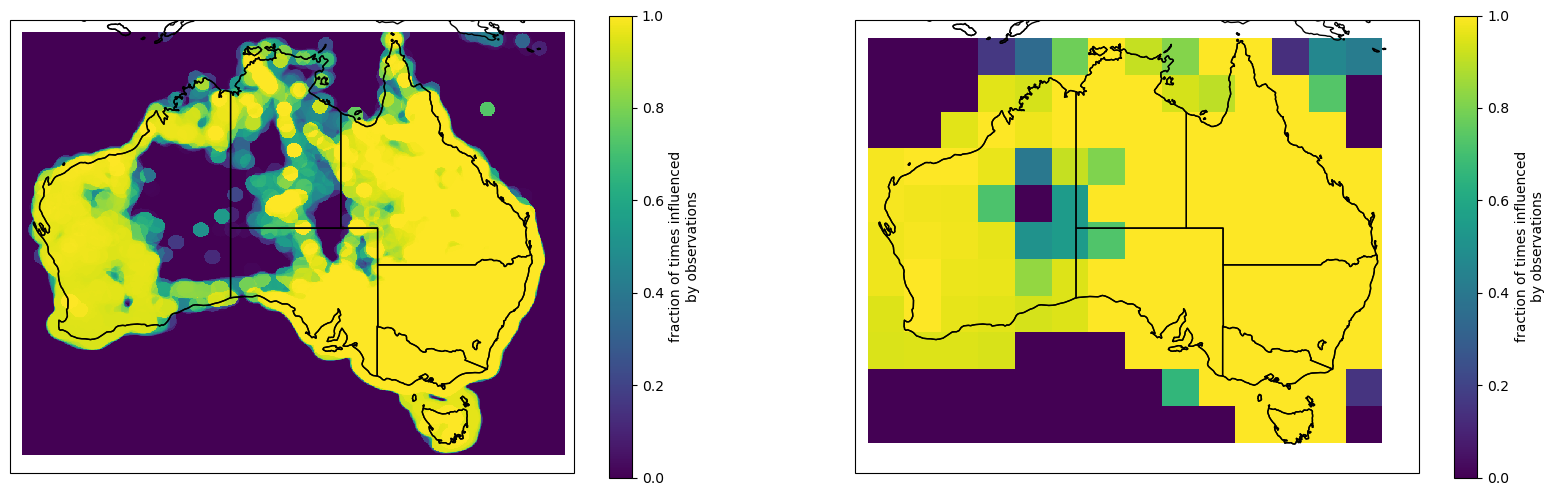

In [5]:
fig = plt.figure(figsize=[20,6])
ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())

map_extent = [111, 157, -9, -46]

im1 = ds_fraction['fraction'].plot(
    ax=ax1,
    transform=ccrs.PlateCarree()
)
ax1.coastlines()
ax1.add_feature(cartopy.feature.STATES)
ax1.set_extent(map_extent, crs=ccrs.PlateCarree())

im2 = ds_fraction_coarse['fraction'].plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
)
#ax1.set_title("Fraction of days influenced by obs (1900-2022)")
ax2.coastlines()
ax2.add_feature(cartopy.feature.STATES)
ax2.set_extent(map_extent, crs=ccrs.PlateCarree())

plt.show()

## TXx

In [6]:
#txx_obs_file = '/Users/irv033/Desktop/txx_AGCD-CSIRO_r05_1901-2024_annual-jul-to-jun_aus.nc'
txx_obs_file = '/Users/irv033/Desktop/unseen-bias/txx_AGCD-CSIRO_1901-2024_annual-jul-to-jun_AUS300i.nc'
ds_obs = fileio.open_dataset(txx_obs_file)

In [7]:
ds_obs

<xarray.Dataset> Size: 767kB
Dimensions:     (time: 113, lat: 11, lon: 14)
Coordinates:
  * lat         (lat) float64 88B -42.0 -39.0 -36.0 -33.0 ... -18.0 -15.0 -12.0
  * lon         (lon) float64 112B 113.5 116.5 119.5 122.5 ... 146.5 149.5 152.5
  * time        (time) object 904B 1911-06-30 00:00:00 ... 2023-06-30 00:00:00
    event_time  (time, lat, lon) <U10 696kB dask.array<chunksize=(113, 11, 14), meta=np.ndarray>
Data variables:
    tasmax      (time, lat, lon) float32 70kB dask.array<chunksize=(113, 11, 14), meta=np.ndarray>
Attributes: (12/34)
    regrid_method:                 conservative
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Tue May 20 16:17:01 2025: /g/data/xv83/dbi...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    ...                            ...
    url:                           http://www.bom.gov.au/climate/
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily maximum temperature station data...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...

In [8]:
da_obs = mask_ocean(ds_obs['tasmax'], overlap_threshold=0.01)

In [9]:
gev_obs = eva.fit_gev(da_obs)
gev_obs = gev_obs.compute()

In [10]:
#txx_model_file = '/Users/irv033/Desktop/txx_CanESM5-dcppA-hindcast_196101-201701_annual-jul-to-jun_aus.nc'
#txx_model_file = '/Users/irv033/Desktop/unseen-bias/txx_CanESM5-dcppA-hindcast_196101-201701_annual-jul-to-jun_AUS300i.nc'
#ds_model = fileio.open_dataset(txx_model_file)
#ds_model_stacked = ds_model.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [11]:
#da_model = mask_ocean(ds_model_stacked['tasmax'])

In [12]:
#gev_model = eva.fit_gev(da_model, core_dim='sample')
#gev_model = gev_model.compute()

In [13]:
#gev_diff = gev_model - gev_obs

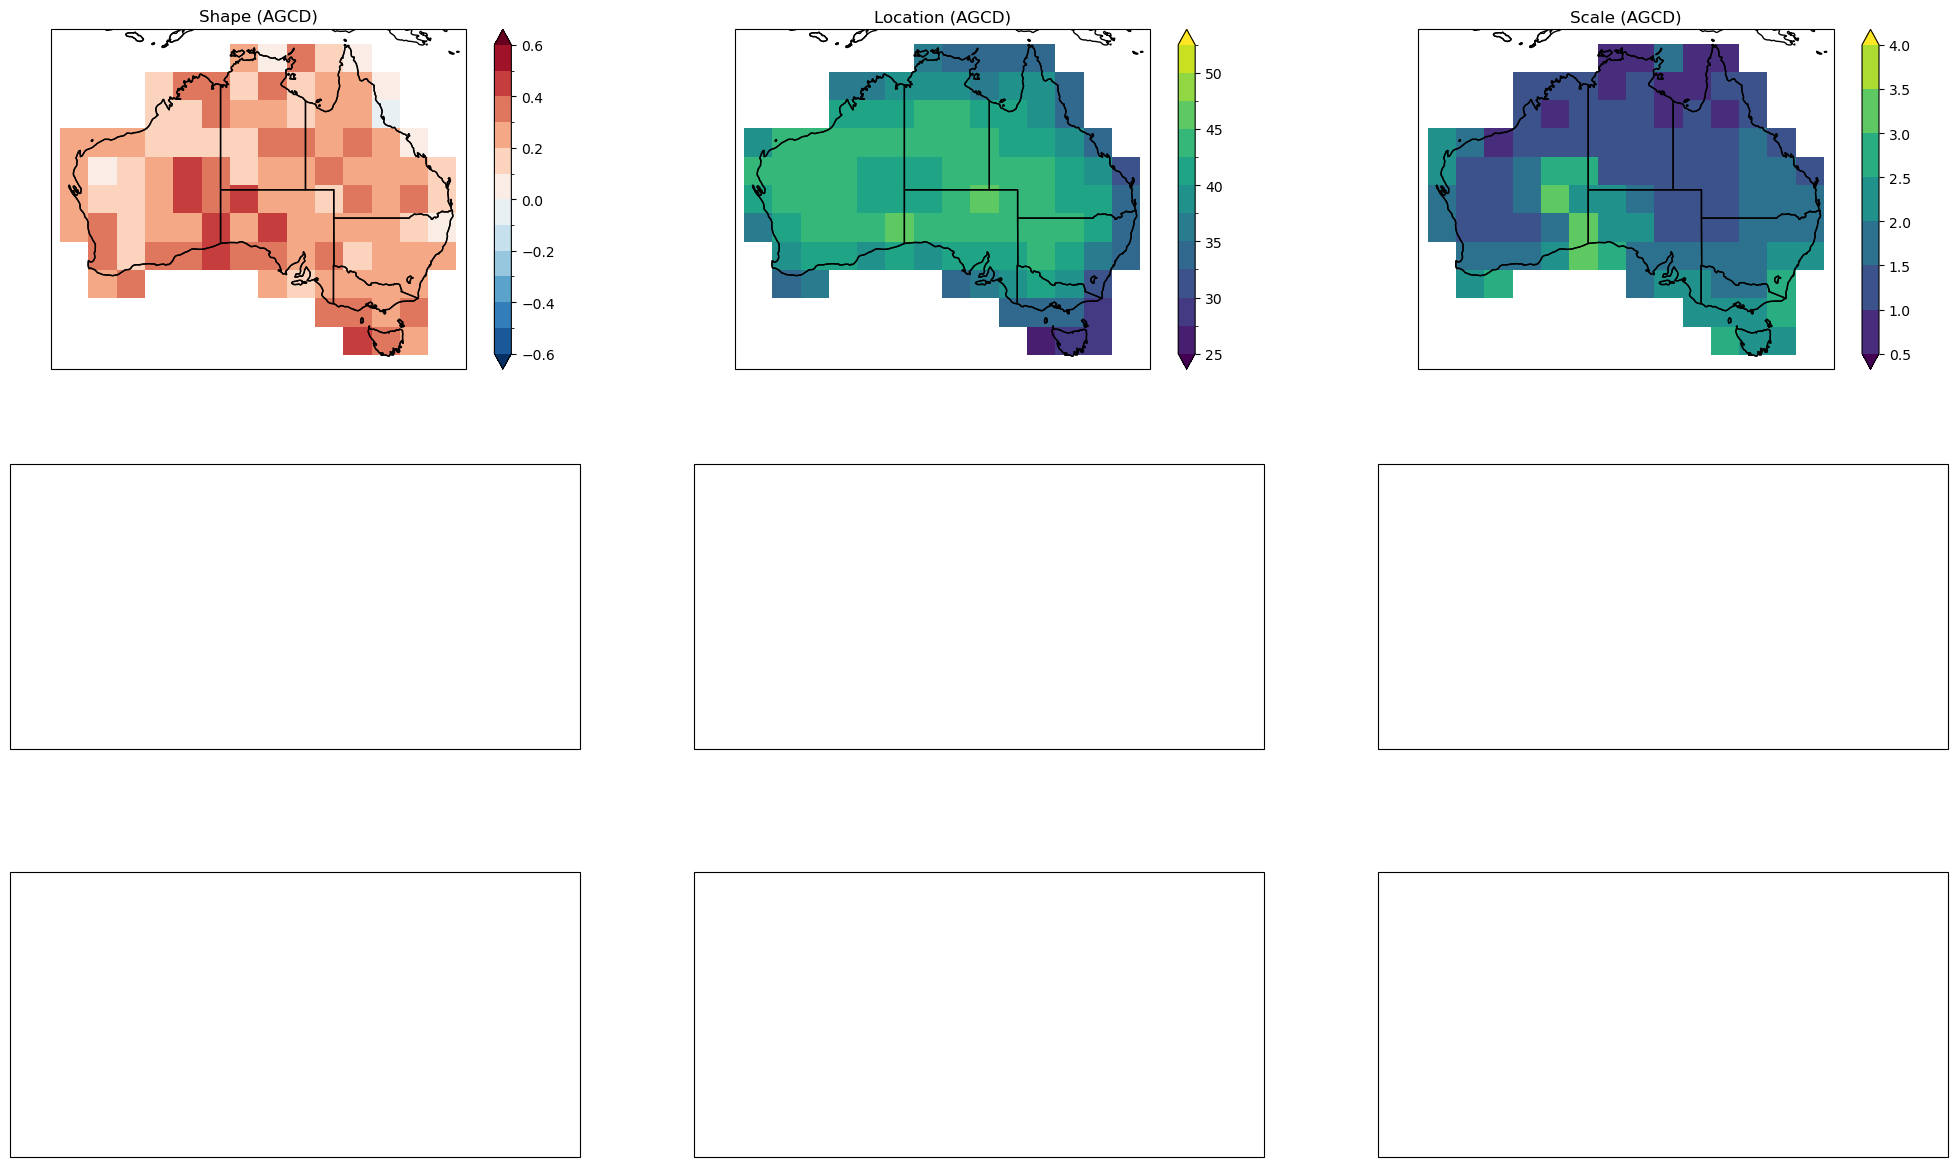

In [14]:
fig = plt.figure(figsize=[25, 15])
ax1 = fig.add_subplot(331, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(332, projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(333, projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(334, projection=ccrs.PlateCarree())
ax5 = fig.add_subplot(335, projection=ccrs.PlateCarree())
ax6 = fig.add_subplot(336, projection=ccrs.PlateCarree())
ax7 = fig.add_subplot(337, projection=ccrs.PlateCarree())
ax8 = fig.add_subplot(338, projection=ccrs.PlateCarree())
ax9 = fig.add_subplot(339, projection=ccrs.PlateCarree())

shape_levels = [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
shape_cmap = 'RdBu_r'
loc_levels = [25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5]
loc_cmap = 'viridis'
scale_levels = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4.0]
scale_cmap = 'viridis'

map_extent = [111, 155, -9, -45]

# AGCD

im1 = gev_obs.sel({'dparams': 'c'}).plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=shape_cmap,
    levels=shape_levels,
    extend='both',
#    add_colorbar=False,
    cbar_kwargs={'label': ' '},
)
ax1.set_title("Shape (AGCD)")
ax1.coastlines()
ax1.add_feature(cartopy.feature.STATES)
ax1.set_extent(map_extent, crs=ccrs.PlateCarree())

im2 = gev_obs.sel({'dparams': 'loc'}).plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=loc_cmap,
    levels=loc_levels,
    extend='both',
#    add_colorbar=False,
    cbar_kwargs={'label': ' '},
)
ax2.set_title("Location (AGCD)")
ax2.coastlines()
ax2.add_feature(cartopy.feature.STATES)
ax2.set_extent(map_extent, crs=ccrs.PlateCarree())

im3 = gev_obs.sel({'dparams': 'scale'}).plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap=scale_cmap,
    levels=scale_levels,
    extend='both',
#    add_colorbar=False,
    cbar_kwargs={'label': ' '},
)
ax3.set_title("Scale (AGCD)")
ax3.coastlines()
ax3.add_feature(cartopy.feature.STATES)
ax3.set_extent(map_extent, crs=ccrs.PlateCarree())

# Model

#im4 = gev_model.sel({'dparams': 'c'}).plot(
#    ax=ax4,
#    transform=ccrs.PlateCarree(),
#    cmap=shape_cmap,
#    levels=shape_levels,
#    extend='both',
#    add_colorbar=False,
#    cbar_kwargs={'label': ' '},
#)
#ax4.set_title("Shape (CanESM5)")
#ax4.coastlines()
#ax4.add_feature(cartopy.feature.STATES)
#ax4.set_extent(map_extent, crs=ccrs.PlateCarree())

#im5 = gev_model.sel({'dparams': 'loc'}).plot(
#    ax=ax5,
#    transform=ccrs.PlateCarree(),
#    cmap=loc_cmap,
#    levels=loc_levels,
#    extend='both',
#    add_colorbar=False,
#    cbar_kwargs={'label': ' '},
#)
#ax5.set_title("Location (CanESM5)")
#ax5.coastlines()
#ax5.add_feature(cartopy.feature.STATES)
#ax5.set_extent(map_extent, crs=ccrs.PlateCarree())

#im6 = gev_model.sel({'dparams': 'scale'}).plot(
#    ax=ax6,
#    transform=ccrs.PlateCarree(),
#    cmap=scale_cmap,
#    levels=scale_levels,
#    extend='both',
#    add_colorbar=False,
#    cbar_kwargs={'label': ' '},
#)
#ax6.set_title("Scale (CanESM5)")
#ax6.coastlines()
#ax6.add_feature(cartopy.feature.STATES)
#ax6.set_extent(map_extent, crs=ccrs.PlateCarree())

# Difference (model - obs)

#im7 = gev_diff.sel({'dparams': 'c'}).plot(
#    ax=ax7,
#    transform=ccrs.PlateCarree(),
#    extend='both',
#    cbar_kwargs={'label': ' '},
#)
#ax7.set_title("Shape (CanESM5 - AGCD)")
#ax7.coastlines()
#ax7.add_feature(cartopy.feature.STATES)
#ax7.set_extent(map_extent, crs=ccrs.PlateCarree())

#im8 = gev_diff.sel({'dparams': 'loc'}).plot(
#    ax=ax8,
#    transform=ccrs.PlateCarree(),
#    extend='both',
#    cbar_kwargs={'label': ' '},
#)
#ax8.set_title("Location (CanESM5 - AGCD)")
#ax8.coastlines()
#ax8.add_feature(cartopy.feature.STATES)
#ax8.set_extent(map_extent, crs=ccrs.PlateCarree())

#im9 = gev_diff.sel({'dparams': 'scale'}).plot(
#    ax=ax9,
#    transform=ccrs.PlateCarree(),
#    extend='both',
#    cbar_kwargs={'label': ' '},
#)
#ax9.set_title("Scale (CanESM5 - AGCD)")
#ax9.coastlines()
#ax9.add_feature(cartopy.feature.STATES)
#ax9.set_extent(map_extent, crs=ccrs.PlateCarree())

plt.show()

## rx1day

In [22]:
rx1day_obs_file = '/Users/irv033/Desktop/unseen-bias/rx1day_AGCD-CSIRO_1901-2024_annual-jul-to-jun_AUS300i.nc'
ds_obs = fileio.open_dataset(rx1day_obs_file)
da_obs = mask_ocean(ds_obs['pr'], overlap_threshold=0.01)

In [23]:
da_obs = mask_by_pr_ob_fraction(da_obs, threshold=0.8)

In [24]:
gev_obs = eva.fit_gev(da_obs)
gev_obs = gev_obs.compute()

In [25]:
#rx1day_model_file = '/Users/irv033/Desktop/rx1day_CanESM5-dcppA-hindcast_196101-201701_annual-jul-to-jun_AUS300i.nc'
#ds_model = fileio.open_dataset(rx1day_model_file)
#ds_model_stacked = ds_model.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})
#da_model = mask_ocean(ds_model_stacked['pr'])

In [26]:
#gev_model = eva.fit_gev(da_model, core_dim='sample')
#gev_model = gev_model.compute()

In [27]:
#gev_diff = gev_model - gev_obs

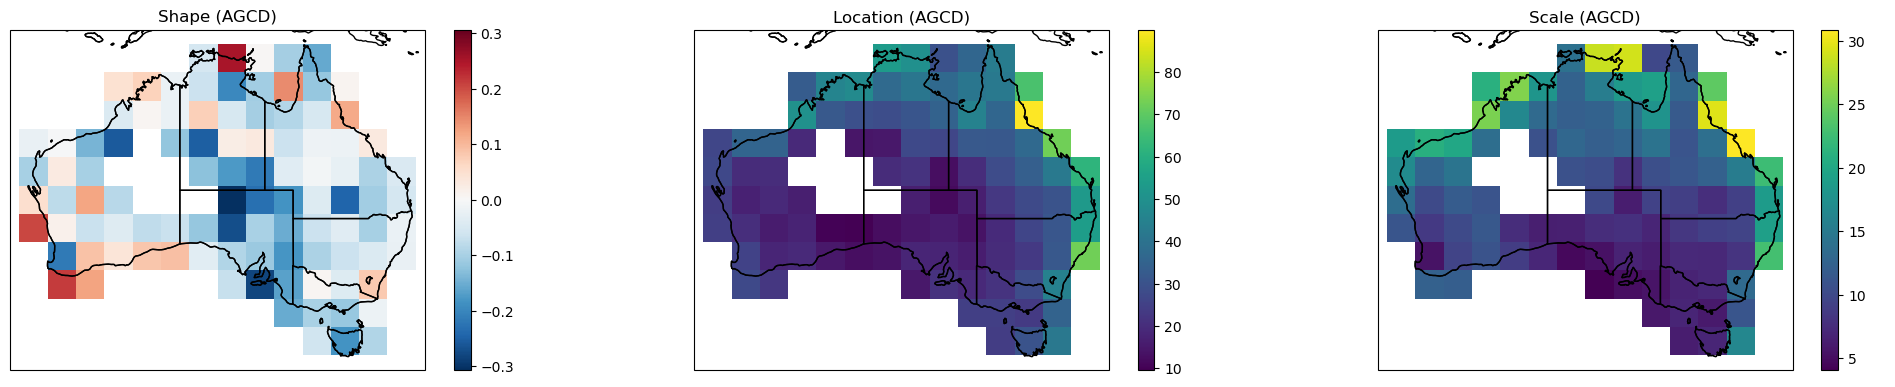

In [28]:
fig = plt.figure(figsize=[25, 15])
ax1 = fig.add_subplot(331, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(332, projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(333, projection=ccrs.PlateCarree())
#ax4 = fig.add_subplot(334, projection=ccrs.PlateCarree())
#ax5 = fig.add_subplot(335, projection=ccrs.PlateCarree())
#ax6 = fig.add_subplot(336, projection=ccrs.PlateCarree())
#ax7 = fig.add_subplot(337, projection=ccrs.PlateCarree())
#ax8 = fig.add_subplot(338, projection=ccrs.PlateCarree())
#ax9 = fig.add_subplot(339, projection=ccrs.PlateCarree())

shape_levels = [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
shape_cmap = 'RdBu_r'
loc_levels = [25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5]
loc_cmap = 'viridis'
scale_levels = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4.0]
scale_cmap = 'viridis'

map_extent = [111, 155, -9, -45]

# AGCD

im1 = gev_obs.sel({'dparams': 'c'}).plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=shape_cmap,
#    levels=shape_levels,
#    extend='both',
#    add_colorbar=False,
    cbar_kwargs={'label': ' '},
)
ax1.set_title("Shape (AGCD)")
ax1.coastlines()
ax1.add_feature(cartopy.feature.STATES)
ax1.set_extent(map_extent, crs=ccrs.PlateCarree())

im2 = gev_obs.sel({'dparams': 'loc'}).plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=loc_cmap,
#    levels=loc_levels,
#    extend='both',
#    add_colorbar=False,
    cbar_kwargs={'label': ' '},
)
ax2.set_title("Location (AGCD)")
ax2.coastlines()
ax2.add_feature(cartopy.feature.STATES)
ax2.set_extent(map_extent, crs=ccrs.PlateCarree())

im3 = gev_obs.sel({'dparams': 'scale'}).plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap=scale_cmap,
#    levels=scale_levels,
#    extend='both',
#    add_colorbar=False,
    cbar_kwargs={'label': ' '},
)
ax3.set_title("Scale (AGCD)")
ax3.coastlines()
ax3.add_feature(cartopy.feature.STATES)
ax3.set_extent(map_extent, crs=ccrs.PlateCarree())

# Model

plt.show()